In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import librosa
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.utils import resample
import string
from nltk.stem import PorterStemmer
from sklearn.utils import class_weight

In [2]:
# Load the MELD Text dataset
meld_csv=r"C:\Users\siddh\Downloads\MELD.Raw\train_sent_emo.csv"
data = pd.read_csv(meld_csv)


In [3]:
# Text preprocessing steps

# 1.Converting text to lower case
def to_lower(text):
    return text.lower()


data['Utterance'] = data['Utterance'].apply(to_lower)
stop_words = set(stopwords.words('english'))


# 2. Removing stopwords
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


data['Utterance'] = data['Utterance'].apply(remove_stopwords)

In [4]:
# 3. Removing punctuations
punctuations_list = string.punctuation


def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)


data['Utterance'] = data['Utterance'].apply(lambda x: remove_punctuations(x))

# 4. Perform stemming to remove plural,tenses
stemmer = PorterStemmer()


def perform_stemming(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)


data['Utterance'] = data['Utterance'].apply(lambda x: perform_stemming(x))

# Convert the labels to binary classes
data['Emotion'] = data['Emotion'].replace({'anger': 1, 'disgust': 1, 'fear': 0, 'joy': 0, 'surprise': 0, 'neutral': 0, 'sadness': 0})


In [5]:
# Over sample the minority class (non - hate)
hate_data = data[data['Emotion'] == 1]
non_hate_data = data[data['Emotion'] == 0]
oversampled_hate_data = resample(hate_data, replace=True, n_samples=len(non_hate_data), random_state=42)

# Combine the oversampled non-hate data with the original hate data
oversampled_data = pd.concat([non_hate_data, oversampled_hate_data])

# Define the maximum number of words to keep in the vocabulary
max_words = 5000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(oversampled_data['Utterance'])
sequences = tokenizer.texts_to_sequences(oversampled_data['Utterance'])

# Pad the sequences to ensure that all sequences have the same length
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Get the count of samples in each class
class_counts = oversampled_data['Emotion'].value_counts()

# Print the count of samples in each class
print(class_counts)

0    8609
1    8609
Name: Emotion, dtype: int64


In [6]:
# Split data into training and testing sets, ensuring stratification
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, oversampled_data['Emotion'], test_size=0.2,
                                                    stratify=oversampled_data['Emotion'], random_state=42)


In [7]:
# Define the CNN model
text_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_length),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
text_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
431/431 [==============================] - 3s 6ms/step - loss: 0.6220 - accuracy: 0.6453 - val_loss: 0.5135 - val_accuracy: 0.7607
Epoch 2/10
431/431 [==============================] - 2s 5ms/step - loss: 0.3964 - accuracy: 0.8267 - val_loss: 0.4110 - val_accuracy: 0.8214
Epoch 3/10
431/431 [==============================] - 2s 5ms/step - loss: 0.2798 - accuracy: 0.8804 - val_loss: 0.3578 - val_accuracy: 0.8522
Epoch 4/10
431/431 [==============================] - 2s 5ms/step - loss: 0.2241 - accuracy: 0.9080 - val_loss: 0.3265 - val_accuracy: 0.8653
Epoch 5/10
431/431 [==============================] - 2s 5ms/step - loss: 0.1896 - accuracy: 0.9214 - val_loss: 0.3192 - val_accuracy: 0.8720
Epoch 6/10
431/431 [==============================] - 2s 5ms/step - loss: 0.1681 - accuracy: 0.9282 - val_loss: 0.3092 - val_accuracy: 0.8830
Epoch 7/10
431/431 [==============================] - 2s 5ms/step - loss: 0.1512 - accuracy: 0.9349 - val_loss: 0.3201 - val_accuracy: 0.8801
Epoch 

In [8]:
# Predict labels for the test set
y_pred = text_model.predict(X_test.reshape((*X_test.shape, 1)))
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision, recall, accuracy, and F1-score
report = classification_report(y_test, y_pred)
print(report)



108/108 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1722
           1       0.85      0.93      0.89      1722

    accuracy                           0.89      3444
   macro avg       0.89      0.89      0.89      3444
weighted avg       0.89      0.89      0.89      3444



In [9]:
# Set the data path
meld_data_path = r"C:\Users\siddh\Downloads\MELD.Raw\train_splits"
data_path = meld_data_path

# Load the MELD dataset annotations
emo_loc = r"C:\Users\siddh\Downloads\MELD.Raw\train_sent_emo.csv"
meld_df = pd.read_csv(emo_loc)

In [10]:
# Parameters for feature extraction
n_mels = 128
n_fft = 2048
hop_length = 512
max_frames = 500


# Function to extract features from audio file
def extract_features(file_path):
    signal, sr = librosa.load(file_path, sr=None)
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    magnitude_spectrogram = np.abs(stft)
    mel_spectrogram = librosa.feature.melspectrogram(S=magnitude_spectrogram, sr=sr, n_mels=n_mels)
    features = np.mean(mel_spectrogram.T, axis=0)
    return features


# Get a list of all the audio files in the data directory
audio_files = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.mp4'):
            audio_files.append(os.path.join(root, file))

# Extract features for all the audio files
X = np.array([extract_features(file) for file in audio_files])

C:\Users\siddh\AppData\Local\Temp\ipykernel_19424\472004079.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=None)
C:\Users\siddh\AppData\Roaming\Python\Python39\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [11]:
# Create label array
y = np.zeros(len(audio_files))
for i, file in enumerate(audio_files):
    file_name = os.path.basename(file)
    utterance_id = int(file_name.split('.')[0].split('_')[-1][3:])
    dialogue_id = int(file_name.split("a")[-1].split("_")[0])
    row = meld_df.loc[(meld_df['Dialogue_ID'] == dialogue_id) & (meld_df['Utterance_ID'] == utterance_id)]
    emotion = row.iloc[0]['Emotion']
    # print(file_name + str(dialogue_id) + '_' + str(utterance_id) + '_' + emotion)

    if 'anger' in emotion or 'disgust' in emotion:
        y[i] = 1

In [12]:
# Randomly over sample the hate class
X_resampled, y_resampled = resample(X[y == 1], y[y == 1],
                                    replace=True, n_samples=X[y == 0].shape[0],
                                    random_state=42)
# Combine the resampled minority class with the majority class
X_resampled = np.concatenate((X[y == 0], X_resampled))
y_resampled = np.concatenate((y[y == 0], y_resampled))

# Count the number of samples in each class before oversampling
num_hate = len(y[y == 1])
num_non_hate = len(y[y == 0])

# Count the number of samples in each class after oversampling
oversampled_num_hate = len(y_resampled[y_resampled == 1])
oversampled_num_non_hate = len(y_resampled[y_resampled == 0])

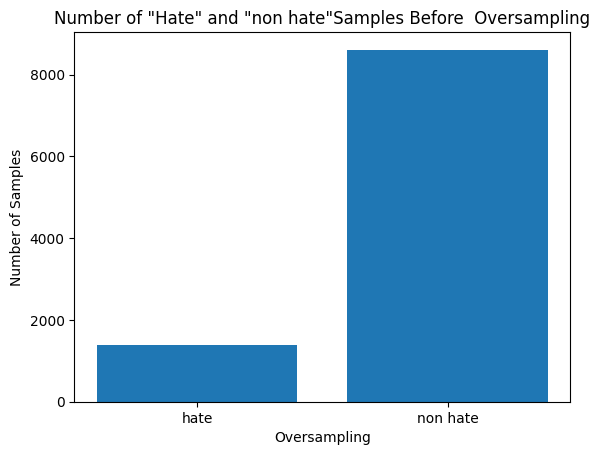

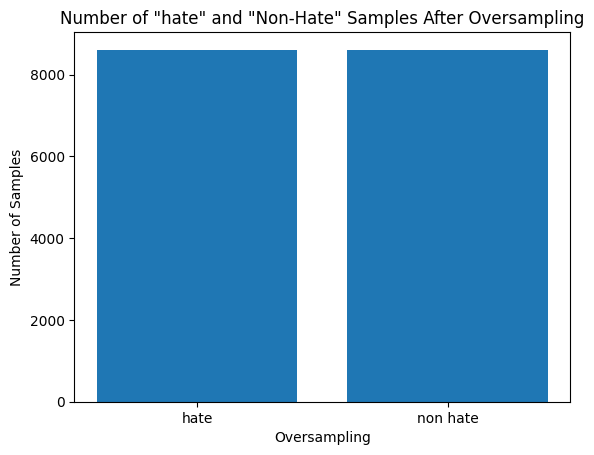

In [13]:
# Create a bar chart for the "Hate" class
fig, ax = plt.subplots()
ax.bar(['hate', 'non hate'], [num_hate, num_non_hate])
ax.set_xlabel('Oversampling')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of "Hate" and "non hate"Samples Before  Oversampling')

# Create a bar chart for the "Non-Hate" class
fig, ax = plt.subplots()
ax.bar(['hate', 'non hate'], [oversampled_num_hate, oversampled_num_non_hate])
ax.set_xlabel('Oversampling')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of "hate" and "Non-Hate" Samples After Oversampling')

plt.show()

In [14]:
# Normalize features
X_mean = X_resampled.mean(axis=0, keepdims=True)
X_std = X_resampled.std(axis=0, keepdims=True)
X_norm = (X_resampled - X_mean) / X_std
print(X_norm)

[[ 1.3360102   2.486549    3.0887585  ...  0.4203311   0.40938708
   0.40941435]
 [ 0.44466275  1.0567315   5.14019    ...  0.43413782  0.4501028
   0.4132389 ]
 [-0.14334816 -0.21550624  0.2785778  ...  0.9430282   0.93112063
   0.9283148 ]
 ...
 [-0.33503357 -0.3157334  -0.4590802  ... -0.17056514 -0.18148278
  -0.16749763]
 [-0.3900667  -0.46166176 -0.5316909  ... -0.2807891  -0.26164415
  -0.27387834]
 [-0.09338541 -0.00961487 -0.3671694  ...  0.19418536  0.19967644
   0.19440919]]


In [15]:
# Split the data into training and testing sets using stratified sampling
train_X, test_X, train_y, test_y = train_test_split(X_norm, y_resampled, test_size=0.2, random_state=42,
                                                    stratify=y_resampled)


In [16]:
# Reshape the training data
train_X = np.expand_dims(train_X, axis=-1)
print('Class distribution in the test set:', np.bincount(test_y.astype(int)))

print('train_X.shape = ', train_X.shape)

Class distribution in the test set: [1722 1722]
train_X.shape =  (13772, 128, 1)


In [17]:
for i in range(len(test_X)):
    input_text = test_X[i]
    label = test_y[i]
    # print("Input text:", input_text)
    print("Label:", label)



Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 1.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 1.0
Label: 0.0
Label: 0.0
Label: 1.0
Label: 1.0

In [18]:
# Define the CNN model
audio_model = Sequential()
audio_model.add(Conv1D(32, 5, activation='relu', input_shape=(128, 1)))
audio_model.add(MaxPooling1D(2))
audio_model.add(Flatten())
audio_model.add(Dense(128, activation='relu'))
audio_model.add(Dense(1, activation='sigmoid'))
audio_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model
history = audio_model.fit(train_X, train_y, epochs=15, batch_size=16, validation_split=0.1)

# Predict labels for the test set
y_pred = audio_model.predict(test_X.reshape((*test_X.shape, 1)))
y_pred = (y_pred > 0.5).astype(int)

Epoch 1/15
775/775 [==============================] - 3s 4ms/step - loss: 0.6567 - accuracy: 0.6091 - val_loss: 0.6369 - val_accuracy: 0.6372
Epoch 2/15
775/775 [==============================] - 3s 4ms/step - loss: 0.6152 - accuracy: 0.6577 - val_loss: 0.6118 - val_accuracy: 0.6575
Epoch 3/15
775/775 [==============================] - 3s 4ms/step - loss: 0.5703 - accuracy: 0.6982 - val_loss: 0.5851 - val_accuracy: 0.6967
Epoch 4/15
775/775 [==============================] - 3s 4ms/step - loss: 0.5131 - accuracy: 0.7464 - val_loss: 0.5324 - val_accuracy: 0.7351
Epoch 5/15
775/775 [==============================] - 3s 4ms/step - loss: 0.4544 - accuracy: 0.7891 - val_loss: 0.5258 - val_accuracy: 0.7409
Epoch 6/15
775/775 [==============================] - 3s 4ms/step - loss: 0.3960 - accuracy: 0.8257 - val_loss: 0.4736 - val_accuracy: 0.7917
Epoch 7/15
775/775 [==============================] - 3s 4ms/step - loss: 0.3457 - accuracy: 0.8541 - val_loss: 0.4410 - val_accuracy: 0.8019
Epoch 

In [20]:
# Calculate precision, recall, accuracy, and F1-score
report = classification_report(test_y, y_pred)
print(report)


              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88      1722
         1.0       0.83      0.98      0.90      1722

    accuracy                           0.89      3444
   macro avg       0.90      0.89      0.89      3444
weighted avg       0.90      0.89      0.89      3444



In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, oversampled_data['Emotion'], test_size=0.2,
                                                    stratify=oversampled_data['Emotion'], random_state=42)
train_X, test_X, train_y, test_y = train_test_split(X_norm, y_resampled, test_size=0.2, random_state=42,
                                                    stratify=y_resampled)

In [22]:
# reshape text data
X_train_text = X_train.reshape(X_train.shape[0], max_length, 1)
X_test_text = X_test.reshape(X_test.shape[0], max_length, 1)


# Define the input layers for the multimodal model
text_input = tf.keras.layers.Input(shape=(max_length,))
audio_input = tf.keras.layers.Input(shape=(128, 1))

In [23]:
# Pass the text input through the NLP model
text_output = text_model(text_input)

# Pass the audio input through the CNN model
audio_output = audio_model(audio_input)

# Concatenate the outputs of the two models
merged = tf.keras.layers.concatenate([text_output, audio_output])

# Add a dense layer to combine the outputs of the two models
merged = tf.keras.layers.Dense(16, activation='relu')(merged)

# Add a dropout layer to prevent over fitting
merged = tf.keras.layers.Dropout(0.5)(merged)

# Add the output layer
merged = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

# Create the multimodal model
model = tf.keras.models.Model(inputs=[text_input, audio_input], outputs=merged)

In [24]:
# Compile the multimodal model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print('texttrain X =', X_train.shape)
print('audiotrain X =', train_X.shape)
print('texttrain y =', y_train.shape)
print('audiotrain Y =', train_y.shape)


texttrain X = (13774, 100)
audiotrain X = (13772, 128)
texttrain y = (13774,)
audiotrain Y = (13772,)


In [25]:
# reshaping
X_train_text_split = X_train[:13248] #13248
y_train_text_split = y_train[:13248]
X_train_audio_split = train_X[:13248]
y_train_audio_split = train_y[:13248]
print('After reshaping')
print('texttrain X =', X_train.shape)
print('audiotrain X =', train_X.shape)
print('texttrain y =', y_train.shape)
print('audiotrain Y =', train_y.shape)

After reshaping
texttrain X = (13774, 100)
audiotrain X = (13772, 128)
texttrain y = (13774,)
audiotrain Y = (13772,)


C:\Users\siddh\AppData\Local\Temp\ipykernel_19424\1194684329.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train_text_split = y_train[:13248]


In [26]:
# Calculate class weights
class_weights = {0: 1, 1: len(y_train_audio_split) / sum(y_train_audio_split)}
print('Class distribution in the test set:', np.bincount(y_train_audio_split.astype(int)))

# Fit the model with class weights
model.fit([X_train_text_split, train_X], y_train_audio_split, epochs=10, batch_size=32, validation_split=0.1, shuffle=True, class_weight=class_weights)


Class distribution in the test set: [6606 6642]
Epoch 1/10
373/373 [==============================] - 4s 8ms/step - loss: 0.6945 - accuracy: 0.6297 - val_loss: 0.4451 - val_accuracy: 0.8913
Epoch 2/10
373/373 [==============================] - 3s 7ms/step - loss: 0.4106 - accuracy: 0.9079 - val_loss: 0.3599 - val_accuracy: 0.9019
Epoch 3/10
373/373 [==============================] - 3s 7ms/step - loss: 0.3115 - accuracy: 0.9535 - val_loss: 0.2949 - val_accuracy: 0.9298
Epoch 4/10
373/373 [==============================] - 3s 7ms/step - loss: 0.2628 - accuracy: 0.9602 - val_loss: 0.3872 - val_accuracy: 0.9042
Epoch 5/10
373/373 [==============================] - 3s 7ms/step - loss: 0.2311 - accuracy: 0.9641 - val_loss: 0.3984 - val_accuracy: 0.9064
Epoch 6/10
373/373 [==============================] - 3s 7ms/step - loss: 0.2154 - accuracy: 0.9666 - val_loss: 0.2833 - val_accuracy: 0.9442
Epoch 7/10
373/373 [==============================] - 3s 7ms/step - loss: 0.1540 - accuracy: 0.9805 

In [27]:
# Predict labels for the test set for audio and text
audio_y_pred = audio_model.predict(test_X.reshape((*test_X.shape, 1)))
audio_y_pred = (audio_y_pred > 0.5).astype(int)
text_y_pred = text_model.predict(X_test.reshape((*X_test.shape, 1)))
text_y_pred = (text_y_pred > 0.5).astype(int)

108/108 [==============================] - 0s 2ms/step


In [28]:
# Combine the predicted labels
combined_y_pred = []
for i in range(len(audio_y_pred)):
    if audio_y_pred[i] + text_y_pred[i] >= 1:
        combined_y_pred.append(1)
    else:
        combined_y_pred.append(0)
combined_y_pred = np.array(combined_y_pred)

In [29]:
# Calculate precision, recall, accuracy, and F1-score
report = classification_report(test_y, combined_y_pred)
print(report)

# Calculate TP, TN, FP, FN for the combined predictions
combined_TP = np.sum((test_y == 1) & (combined_y_pred == 1))
combined_TN = np.sum((test_y == 0) & (combined_y_pred == 0))
combined_FP = np.sum((test_y == 0) & (combined_y_pred == 1))
combined_FN = np.sum((test_y == 1) & (combined_y_pred == 0))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93      1722
         1.0       0.90      0.97      0.94      1722

    accuracy                           0.93      3444
   macro avg       0.94      0.93      0.93      3444
weighted avg       0.94      0.93      0.93      3444



In [30]:
# Calculate precision, recall, accuracy, and F1-score for the combined predictions
combined_precision = combined_TP / (combined_TP + combined_FP)
combined_recall = combined_TP / (combined_TP + combined_FN)
combined_accuracy = (combined_TP + combined_TN) / (combined_TP + combined_TN + combined_FP + combined_FN)
combined_f1_score = 2 * (combined_precision * combined_recall) / (combined_precision + combined_recall)


In [31]:
# Print the results
print("Combined Metrics:")
print(f"Precision: {combined_precision:.3f}")
print(f"Recall: {combined_recall:.3f}")
print(f"Accuracy: {combined_accuracy:.3f}")
print(f"F1-Score: {combined_f1_score:.3f}")

Combined Metrics:
Precision: 0.905
Recall: 0.967
Accuracy: 0.933
F1-Score: 0.935


In [32]:
# Prediction on new_text and new_audio as the new input data
# Preprocess the text data
new_text = 'ass-hat'
new_audio = r'C:\Users\siddh\Downloads\MELD.Raw\train_splits\dia0_utt7.mp4'
new_text_sequence = tokenizer.texts_to_sequences([new_text])
new_text_padded_sequence = pad_sequences(new_text_sequence, maxlen=max_length, padding='post', truncating='post')

# Preprocess the audio data
new_audio_features = extract_features(new_audio)
new_audio_norm = (new_audio_features - X_mean) / X_std
new_audio_norm_reshaped = new_audio_norm.reshape((1, 128, 1))

# Get the predicted label
predicted_label = model.predict([new_text_padded_sequence, new_audio_norm_reshaped])

if predicted_label > 0.5:
    print("The model classified the new audio file as hate.")
else:
    print("The model classified the new audio file as non-hate.")

C:\Users\siddh\AppData\Local\Temp\ipykernel_19424\472004079.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=None)
C:\Users\siddh\AppData\Roaming\Python\Python39\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 112ms/step
The model classified the new audio file as non-hate.
